In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat May  2 19:00:01 2020

@author: yongjiaxu
"""

import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import import_ipynb
import solvers

def solve(method, n, rfunc, xa, xb, A, B, C, alpha, beta):
    h = (xb-xa)/(n+1);  # mesh size
        
    # matrix entry on tri-dialgonals
    coA= A/(h**2) - B/(2*h)
    coB= C-2*A/(h**2)
    coC= A/(h**2) + B/(2*h)

    x = np.zeros(n) #x-values
    sol = np.zeros(n) # solution
    r = np.zeros(n)    #right handside of the equations

    # Get the right hand side value on at grids
    for i in range(n):
        x[i] = (i+1) * h + xa
        r[i] = rfunc(x[i])
    r[0] = r[0] - alpha*coA
    r[n-1] = r[n-1] - beta *coC
    
    if (method == 0):
        # Thomas's algorithm
        # assign values for a,b,c - tridiagonals
        a = np.zeros(n); b = np.zeros(n); c = np.zeros(n)
        a += coA; b += coB; c += coC
        sol = Thomas(a,b,c,r)
        iteration = -1
    elif(method == 1):
        # Jacobi iterative method
        sol, iteration = Jacobi(coA, coB, coC, r, n)
    elif(method == 2):
        # Gauss-Seidel iterative method
        sol, iteration = Gauss_Seidel(coA, coB, coC, r, n)
    elif(method == 3):
        # Successive over-relaxation
        wopt = 2/(1+np.sqrt(1-np.cos(np.pi*h)**2)) #optimized omega for tridiagonal system
        sol, iteration = SOR(coA, coB, coC, r, n, wopt)
    elif(method == 4):
        # Gaussian Elimination:
        # build the matrix
        M = np.zeros((n,n+1))
        for i in range(1,n-1):
            M[i,i] = coB
            M[i, i-1] = coA
            M[i, i+1] = coC
        M[0,0] = coB
        M[0, 1] = coC
        M[n-1, n-2] = coA
        M[n-1,n-1] = coB
        for i in range(n):
            M[i,n] = r[i]
        sol = solvers.gaussElim(M)
        iteration = -1

    return x, sol, iteration


#LU factorization based on Thomas's algorithm
def Thomas(a,b,c,r):
    n = len(r)
    w = np.zeros(n,float)
    l = np.zeros(n,float)
    u = np.zeros(n,float)
    z = np.zeros(n,float)
    #Determine L,U factors
    u[0] = b[0]
    
    for k in range(1, n):
        l[k] = a[k]/u[k-1]
        u[k] = b[k] - l[k]*c[k-1]
        
    # Solve Lz = r
    z[0] = r[0]
    for k in range(1, n):
        z[k] = r[k] - l[k]*z[k-1]

    # Solve Uw = z.
    w[n-1] = z[n-1]/u[n-1]
    for k in range(n-2,-1,-1):
        w[k] = (z[k] - c[k]*w[k+1])/u[k]
        
    return w


def Jacobi(coA, coB, coC, r, n, tol = 1e-8):
    # sol1 and sol are two consequent solutions
    # if the difference between two is smaller than tolerance 
    # then assume the result has been found
    sol1 = np.zeros(n)
    sol = np.zeros(n)
    iteration = 0
    err = 1
    while (err > tol):
        iteration += 1
        #calculation part
        sol[0] = (r[0] - coC * sol1[1])/coB
        for i in range(1, n-1):
            sol[i] = (r[i] - coA * sol1[i-1] - coC * sol1[i+1])/coB
        sol[n-1] = (r[n-1] - coA * sol1[n-2])/coB
        
        err = max(np.absolute(sol1-sol))
        sol1 = sol.copy()
        
    return sol, iteration


def Gauss_Seidel(coA, coB, coC, r, n, tol = 1e-8):
    # sol1 and sol are two consequent solutions
    # if the difference between two is smaller than tolerance 
    # then assume the result has been found
    sol1 = np.zeros(n)
    sol = np.zeros(n)
    iteration = 0
    err = 1
    while (err>tol):
        iteration += 1
        #calculation part 
        #** notice here we use only sol because the only place we use the previous solution
        # is to use the next value and since that value in sol is not updated
        # we could just use the same array
        sol[0] = (r[0] - coC * sol[1])/coB
        for i in range(1, n-1):
            sol[i] = (r[i] - coA * sol[i-1] - coC * sol[i+1])/coB
        sol[n-1] = (r[n-1] - coA * sol[n-2])/coB
        
        err = max(np.absolute(sol1-sol))
        sol1 = sol.copy()
        
    return sol, iteration


def SOR(coA, coB, coC, r, n, wopt, tol = 1e-8):
    # sol1 and sol are two consequent solutions
    # if the difference between two is smaller than tolerance 
    # then assume the result has been found
    sol1 = np.zeros(n)
    sol = np.zeros(n)
    iteration = 0
    err = 1
    while (err>tol):
        iteration += 1
        #calculation part 
        #** notice here we use only sol because the only place we use the previous solution
        # is to use the next value and since that value in sol is not updated
        # we could just use the same array
        sol[0] = (r[0] - coC * sol[1])/coB
        for i in range(1,n-1):
            sol[i] = (coB*sol[i] + (wopt * (r[i] - coA * sol[i-1] - coB * sol[i] - coC * sol[i+1])))/coB
        sol[n-1] = (r[n-1] - coA * sol[n-2])/coB
        
        err = max(np.absolute(sol1-sol))
        sol1 = sol.copy()
        
    return sol, iteration 
    

def ode_perf(s, rf, xa, xb, coeff, n, m, T, I, E):

    alpha = s(xa); beta = s(xb)
    
    l = []
    if T == True:
        time = {}; 
        for i in m:
            time[i] = l.copy()
    if I == True:
        iteration = {};
        for i in m:
            iteration[i] = l.copy()
    if E == True:
        error = {};
        for i in m:
            error[i] = l.copy()
            
    for k in range(len(n)):
        for i in m:
            start = timer()
            x, sol, it = solve(i, n[k], rf, xa, xb, coeff[0], coeff[1], coeff[2], alpha, beta)
            end = timer()
            if T == True: time[i].append(end-start)
            if I == True: iteration[i].append(it)
            if E == True: y = s(x);  err = max(np.abs(y-sol)); error[i].append(err)
        
    name = {}
    name[0] = 'Thomas'
    name[1] = 'Jacobi'
    name[2] = 'Gauss-Seidel'
    name[3] = 'SOR'
    name[4] = 'Gauss-Elimination'
    
    linestyle = {}
    linestyle[0] = 'r|-'
    linestyle[1] = 'bo-'
    linestyle[2] = 'g*-'
    linestyle[3] = 'y--'
    linestyle[4] = 'c-'
    
    if T == True:
        fig = plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
        for i in m:
            plt.plot(n, time[i], linestyle[i], lw = 1, markersize = 2.5, label = name[i])
        plt.legend()
        plt.title('Runtime performance')
        plt.xlabel('# of data points')
        plt.ylabel('Runtime(s)')
#        plt.savefig('Runtime_'+ str(n[0]) + '_' + str(n[-1]) + '.png')
        plt.show()

    if I == True:
        fig = plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
        for i in m:
            plt.plot(n, iteration[i], linestyle[i], lw = 1, markersize = 2.5, label = name[i])  
        plt.title('# of iterations comparison')
        plt.xlabel('# of data points')
        plt.ylabel('# of iterations')
        plt.ylim(ymin = 0)
        plt.legend()
#        plt.savefig('Iterations_'+ str(n[0]) + '_' + str(n[-1]) + '.png')
        plt.show()
        
    if E == True:
        fig = plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
        for i in m:
            plt.semilogy(n, error[i], linestyle[i], lw = 1, markersize = 2.5, label = name[i])  
        plt.title('Error comparison')
        plt.xlabel('# of data points')
        plt.ylabel('Error')
        plt.legend()
#        plt.savefig('Error_'+ str(n[0]) + '_' + str(n[-1]) + '.png')
        plt.show()
    
    
def ode_interface(s, rf, xa, xb, coeff, n = [10,20,30,40,50], m = [0,1,2,3,4], T = True, I = True, E = True):
    
    ode_perf(s, rf, xa, xb, coeff, n, m, T, I, E)


def solution_demo(s, rf, xa, xb, coeff, n, m):
    # exact value at a fine mesh
    d=0.0025
    xe = np.arange(xa,xb+d,d)
    ye = xe.copy()
    for i in range(len(xe)):
        ye[i] = s(xe[i])
        
    alpha = s(xa); beta = s(xb)   
    x, sol, it = solve(m, n, rf, xa, xb, coeff[0], coeff[1], coeff[2], alpha, beta) 
    
    
    fig = plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
    plt.plot(xe, ye, 'b-', label = 'real value')
    plt.plot(x, sol, 'ro', markersize = 3.5, label = 'data points')
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.legend()
    plt.show()

importing Jupyter notebook from solvers.ipynb


In [2]:
## f1 is the actual solution to the ode
s1 = lambda x: (2*np.exp(1))*x*(np.exp(-x)) - np.exp(x)
rf1 = lambda x: -4*(np.exp(x))
xa = 0; xb = 2;
coeff = [1,2,1]

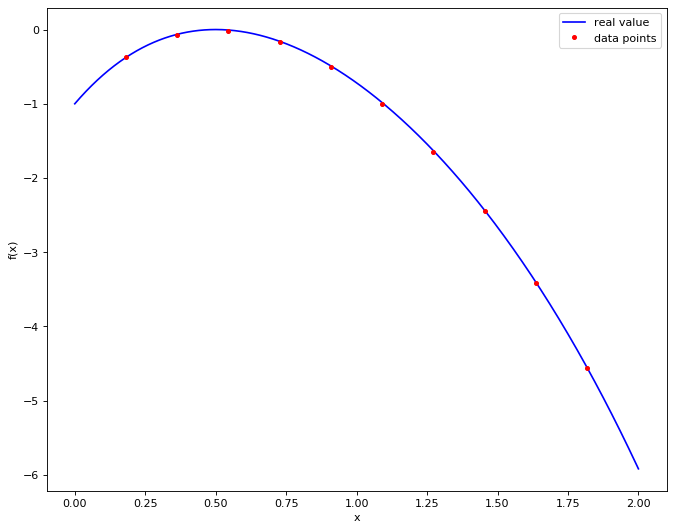

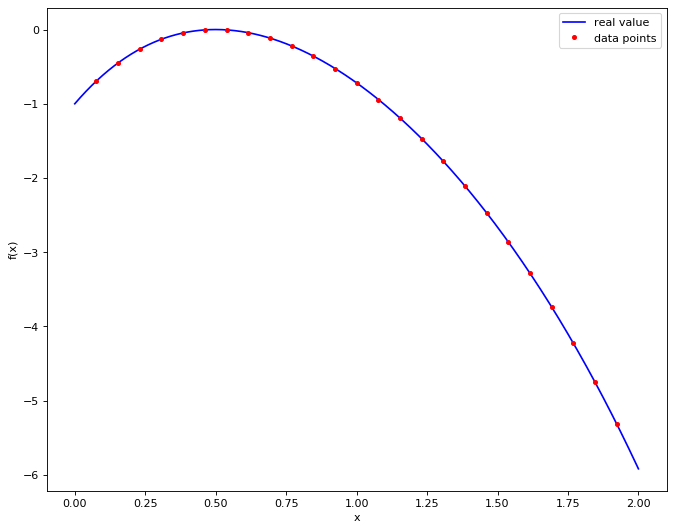

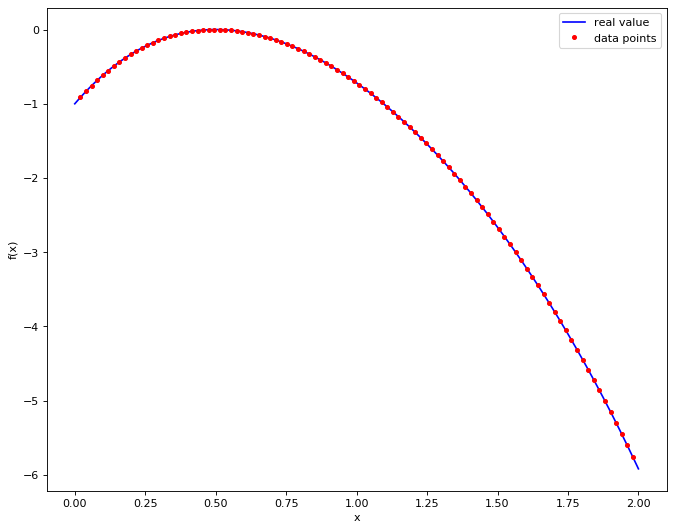

In [3]:
for i in [10,25,100]:
    solution_demo(s1, rf1, xa, xb, coeff, i, 0)